# Handwritten Digits Classifier
Dataset: MNIST

Model: LeNet-5

This notebook contains helpful explainations (and some more code than the unexplained version) that help getting started in PyTorch. This also helps those who have started their Deep Learning journey.

(Note how PyTorch uses "minibatches" and "batches" interchangeably. This holds true in the comments below.)

### References:
- [PyTorch Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
- Official PyTorch Documentation

# Libraries
Some packages are reimported to be able to refer to them more easily.

In [1]:
#Import libraries
import torch #for tensors, GPU enabled.
import torchvision #for Computer Vision
import torchvision.transforms as transforms #for common image preprocessing. Inputs are PIL/Tensor image.
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn #for building NNs. Only supports inputs that are a mini-batch of samples, and not a single sample (In which case, use input.unsqueeze(0) to add a fake batch dimension)
import torch.nn.functional as F #for common functions like ReLu, pooling, etc.
import torch.optim as optim #a small package implementing various optimization algorithms. can use various different update rules such as SGD, Adam, etc.

# Preparing the data
In the MNIST dataset, each image has 1 channel (grayscale), is 28*28 pixels, and is accompanied with its target label.

The train set has 60,000 images and the test set has 10,000 images.

For other specifics, visit the [official website](http://yann.lecun.com/exdb/mnist/).

You don't have to worry about navigating this page directly, as PyTorch has pre-loaded datasets.

During the preprocessing, we resize to 32*32 px since the LeNet-5 architecture takes in images of those dimensions.

In [2]:
#Prepare for preprocessing:
transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
# ToTensor() converts a PIL Image or numpy.ndarray (H x W x C) to a torch.FloatTensor of shape (C x H x W), where C is the no. of channels
# Normalize() takes parameters as the channel's mean and Standard Deviation. This is done so that each pixel is ensured the same Standard Normal data distribution, which makes convergence faster  

#Load train dataset:
trainset = torchvision.datasets.MNIST(root='~/.pytorch/MNIST_data/', train = True, download = True, transform = transform)  
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle = True, num_workers = 2, drop_last = True) #Final iterable data that will be taken for training: shuffled in batches

#Load test dataset:
testset = torchvision.datasets.MNIST(root = '~/.pytorch/MNIST_data/', train = False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle = False, num_workers=2, drop_last = True)

classes = ("Zero", "One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine") #Just labels, for our own printing use

#Now, data is in the tensors trainset and testset as: no_of_images*2*1*32*32

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



## Peeking into the dataset
View images in 1 minibatch.

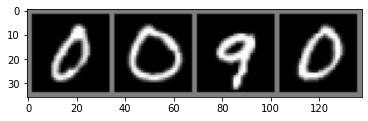

 Zero  Zero  Nine  Zero


In [3]:
#Check how the image is loaded finally
def imshow(img): #A function to plot image(s)
  #we first undo some of the preprocessing to see how the actual image is
  img = img/2 + 0.5 #un-normalize (remember the parameters we passed to Normalize for preprocessing)
  npimg = img.numpy() #convert from Tensor back to numpy's ndarray (needed for the transpose() below)
  plt.imshow(np.transpose(npimg, (1,2,0))) #to plot H vs W, the axes are thus specified
  plt.show() 
  
dataiter = iter(trainloader) #An iterator that enumerates over batches 
images, labels = dataiter.next() #A batch of 4 samples is loaded. Each sample is it's [image, label]. Since we are loading only 1 batch, we won't need a loop
imshow(torchvision.utils.make_grid(images)) 
print(' '.join('%5s' % classes[labels[j]] for j in range(4) )) #Remember: List comprehensions are more efficient than explicit loops!

# Defining the model

## The network class
The layers and their parameters below are all taken from LeNet-5.

In [4]:
#A class to encapsulate the network architecture
class Net(nn.Module): #Must inherit "Module", a base class for all NN modules
  
  def __init__(self): #constructor to define the network's layers.
    super(Net, self).__init__() 
    self.conv1 = nn.Conv2d(1,6,5) #Valid convolution (no padding). Args: 1 input image channel, 6 output channels (/no. of filters), 5x5 square size of the convolving kernel.
                                  #Striding assumed 1, bias is assumed added. Output is again the 4D Tensor - no.of.samples(batch size)*C*H*W
    self.pool = nn.MaxPool2d(2,2) #Args: kernel size, stride
    self.conv2 = nn.Conv2d(6,16,5) 
    self.fc1 = nn.Linear(16*5*5,120) #Args: input, output features. Bias set true. 16*5*5 = 400
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10) 
  
  def forward(self, x): #Forward prop on x, the actual image vector 
    x = self.pool(F.relu(self.conv1(x))) 
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5) #reshaping
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x) #The softmax activation isn't done here as combining it with loss calculations will make it more computationally efficient. Hence, this will automatically be taken care of by the loss criterion that we chose later
    return x

net = Net() 

#Just for info:
print(net) 
params = list(net.parameters()) #shows the learnable parameters of our model
print(len(params)) #no. of parameter tensors (arrays) = no.of.layers*2, as each layer has 1 Weight and 1 Bias array 
for s in range(len(params)): #show the actual no. of weights and biases for each layer
  print(s, ":", params[s].size()) #(W,b)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
10
0 : torch.Size([6, 1, 5, 5])
1 : torch.Size([6])
2 : torch.Size([16, 6, 5, 5])
3 : torch.Size([16])
4 : torch.Size([120, 400])
5 : torch.Size([120])
6 : torch.Size([84, 120])
7 : torch.Size([84])
8 : torch.Size([10, 84])
9 : torch.Size([10])


## The loss function and the update rule
The negative log likelihood loss is apt for multi-class training.

The SGD is a pretty introductory update rule, that a beginner may be familiar with. 

In [5]:
#Deciding the Loss function and Optimizer
criterion = nn.CrossEntropyLoss()  #an optimizer object, that will hold the current state and will update the parameters by step() after gradients are computed by backward().
# This criterion combines nn.LogSoftmax() (hence did not apply activn in the NN Model itself) and nn.NLLLoss() in one single class.
# Input: raw, unnormalized scores for each class (i.e the final layer output of our model) of Tensor dims (minibatch, C classes), along with their Target labels.
# FINAL output is the SCALAR cost (averaged over the minibatch)

optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

# Training the model
Loop over our data iterator, feeding the inputs to the network, and optimize.

In [6]:
x_minibatches=[] #x and y for plotting the training curve later
y_loss=[]
optimizer.zero_grad() #initializes gradients to 0
running_loss = 0.0

for epoch in range(3): 
  print("Epoch loss:", running_loss/1000) #The inner loop runs 15k times, where the loss is reset every 2000th batch. This leaves space for 1000 batches' loss to be recorded, as statistics for every epoch.   
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0): #as said before, the DataLoader enumerates over batches, so i is also the no. of minibatches
     inputs, labels = data
     optimizer.zero_grad() #Zero the existing gradient buffers of all parameters, else gradients will be accumulated (i.e summed) to existing gradients (from the previous batch).
     outputs = net(inputs) #Forward prop. This syntax works (instead of directly calling forward()) because the base Module class allows it (similarly for the next line)
     loss = criterion(outputs, labels) #The scalar loss is held in this object
     loss.backward()  #Backward prop. This is when accumulation of grads happen. 
     optimizer.step()  #Optimizer finally updates the parameters
    
     #Record some statistics:
     running_loss += loss.item()  #Torch.Tensor.item() retrieves the scalar value, rather than a tensor
     if i%2000 == 1999: #For every 2000 minibatches (or 8k images)
       print('[%d, %d] loss: %.3f' %(epoch+1, i+1, running_loss/2000)) 
       x_minibatches.append((i+1)*4+(epoch*60000)) #Record at which stage of the data...
       y_loss.append(running_loss/2000)            #...the loss was recorded. Helps in plotting a graph.
       running_loss = 0.0 #Reset the loss, so we know how the loss changes within a reasonable frame (an average loss from the beginning would be meaningless)

print('Finished training')

#Demo: We will be showing how to save the trained model params and load them back in. However, this isn't a necessary step and one could directly pass the test set to the model class, like we did during training.  
PATH = './MNIST_net.pth' #By convention, PyTorch files have pt/pth extension
torch.save(net.state_dict(), PATH) #recommended to save state dict rather than module for compatibility
# A module’s state dict contains all of its parameters and persistent buffers. (even optims have this, also having hyperparas)

Epoch loss: 0.0
[1, 2000] loss: 1.044
[1, 4000] loss: 0.209
[1, 6000] loss: 0.141
[1, 8000] loss: 0.109
[1, 10000] loss: 0.090
[1, 12000] loss: 0.081
[1, 14000] loss: 0.081
Epoch loss: 0.08143176434358156
[2, 2000] loss: 0.064
[2, 4000] loss: 0.060
[2, 6000] loss: 0.058
[2, 8000] loss: 0.058
[2, 10000] loss: 0.054
[2, 12000] loss: 0.049
[2, 14000] loss: 0.057
Epoch loss: 0.05984801999468891
[3, 2000] loss: 0.038
[3, 4000] loss: 0.040
[3, 6000] loss: 0.042
[3, 8000] loss: 0.037
[3, 10000] loss: 0.040
[3, 12000] loss: 0.044
[3, 14000] loss: 0.042
Finished training


# Peeking into the trained model 

Sample Grads:  tensor([-0.0160,  0.0146,  0.0086, -0.0092, -0.0126, -0.0002])
Sample Paras:  Parameter containing:
tensor([ 0.2372,  0.1222,  0.1215, -0.4027, -0.6526,  0.1432],
       requires_grad=True)


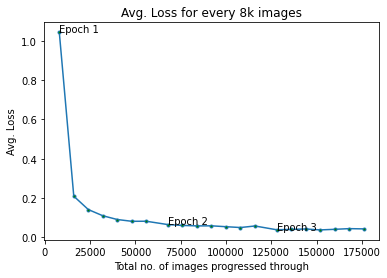

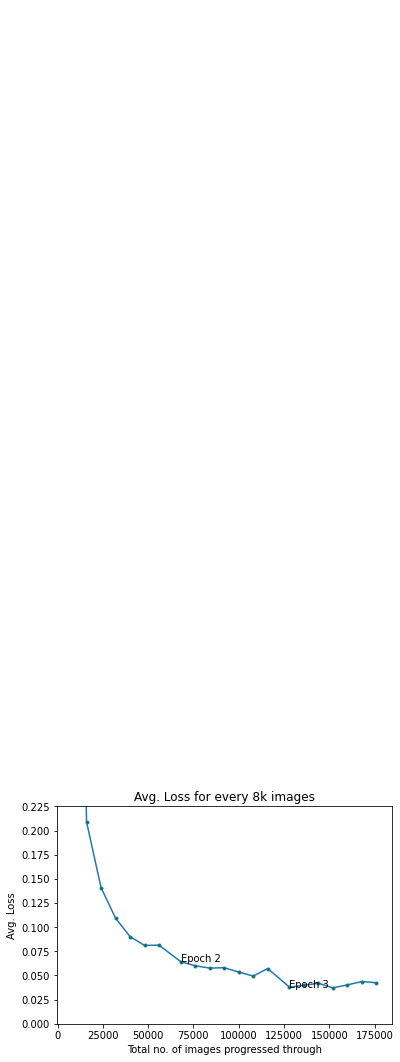

In [7]:
#We can directly see the grads and params of any layer:
print('Sample Grads: ', net.conv1.bias.grad) 
print('Sample Paras: ', net.conv1.bias)
# print(params) prints all params, each W and b. print(net.parameters()) only shows an object in memory. 

#Plot a graph for the loss throughout the training:
plt.plot(x_minibatches, y_loss, marker='.', markerfacecolor='g') 
for i in range(len(x_minibatches)):
    if i%7==0:
        plt.annotate("Epoch " + str(int(i/7)+1), (x_minibatches[i], y_loss[i]))
plt.xlabel("Total no. of images progressed through")
plt.ylabel("Avg. Loss")
plt.title('Avg. Loss for every 8k images')
plt.show()

#From previous graph we see that the scale of just the first plot point makes it imopssible to see the actual progress in later epochs 
#So, zoom in, depending on the first point, while still maintaing a perspective of the 1st-to-2nd points' slope.
plt.ylim(top=0.225)
plt.plot(x_minibatches, y_loss, marker='.', markerfacecolor='g') 
for i in range(len(x_minibatches)):
    if i%7==0:
        plt.annotate("Epoch " + str(int(i/7)+1), (x_minibatches[i], y_loss[i]))
plt.xlabel("Total no. of images progressed through")
plt.ylabel("Avg. Loss")
plt.title('Avg. Loss for every 8k images')
plt.show()

## A live sample test of the predictions made by the model

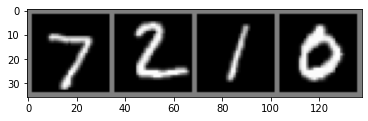

Target labels:  Seven   Two   One  Zero
Predicted labels:  Seven   Two   One  Zero


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next() 
imshow(torchvision.utils.make_grid(images)) #Print images...
print('Target labels: ', ' '.join('%5s' % classes[labels[j]] for j in range(4))) #...and their actual target labels
net = Net()  
net.load_state_dict(torch.load(PATH)) # So we first saved, then load the trained state_dict, then put it in the required module's state_dict
outputs = net(images) #The actual testing. As said before, we can skip all the saving-and-loading and directly do this for the testset
_, predicted = torch.max(outputs, 1) #Second argument tells that we want to vary the column index in search of the max ("outputs" is of 4*10 dims). This gives us the max for each row (image)  
#max() returns 2 things: 1st the actual max value (which we don't need, so '_' is just a placeholder), and 2nd the index where the max elem was found, which also corresponds to the class (which we need)  
#Notice how we didn't have to apply the last activation layer. This saves us from doing an unnecesary layer on the testset

print('Predicted labels: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

# Testing the model
Putting the model through both the test and train sets to see how well it performs.

We add aditional metrics to see how well it's recognizing each class.

In [9]:
#Test set:
correct = 0.0
total = 0.0 
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad(): #no_grad() is a context-manager that disables gradient calculation, use when you are sure you wont do T.backward(). It will reduce memory consumption for computations.
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1) #the .data just specifies not to keep track of changes in the parameters, so use it only if you won't need its grads again. 
    # Though it doesn't make a difference in the code, I mentioned .data here as you might see it elsewhere. It's safer to use .detach() though.
    total+=labels.size(0) 
    correct += (predicted==labels).sum().item() #this 'construct' counts number of same entries across 2 tensors
    # For accuracy per class:
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item() #since True is 1 and False is just 0. 
      class_total[label] += 1
print('Test set accuracy: %f %%' %(100.0*correct/total)) 

# Similarly, for the train set:
correct = 0.0
total = 0.0
with torch.no_grad():
  for data in trainloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total+=labels.size(0) 
    correct += (predicted==labels).sum().item() 
print('Train set accuracy: %f %%' %(100.0*correct/total))

#Print accuracy per class:
avg_acc = 0.0
for i in range(10):
    x = 100.0 * class_correct[i] / class_total[i]
    avg_acc +=x
    print('Accuracy of %5s : %f %%' % (classes[i], x))
avg_acc/=10
print("Average class accuracy: ", avg_acc)

Test set accuracy: 98.750000 %
Train set accuracy: 99.145000 %
Accuracy of  Zero : 99.591837 %
Accuracy of   One : 99.823789 %
Accuracy of   Two : 98.546512 %
Accuracy of Three : 98.910891 %
Accuracy of  Four : 98.167006 %
Accuracy of  Five : 98.766816 %
Accuracy of   Six : 98.434238 %
Accuracy of Seven : 98.346304 %
Accuracy of Eight : 99.178645 %
Accuracy of  Nine : 97.621407 %
Average class accuracy:  98.73874438470673
